# Detecção de Fake News - Preprocessamento

Base de dados usada no projeto: [ISOT Fake News Dataset](https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets/data)

BERT é bem mais robusto do que modelos clássicos de tokenização (como TF-IDF e Bag of Words). O embedding utilizado combina informações semânticas e posicionais, além disso, ele possui um mecanismo de atenção capaz de codificar o contexto de cada token na frase.

Dessa forma, a fase de limpeza do texto não precisa ser muito severa ao realizar o fine-tunning do BERT. Coisas que devem ser evitadas:

- **Não remover pontuação**: BERT foi treinado para entender pontuação como parte do significado.
- **Não remover stopwords**: Palavras como *is*, *the*, *a* são importantes para o contexto.
- **Não aplicar stemming ou lemmatização**: BERT entende as palavras em suas formas originais.
- **Evite limpezas agressivas**: O tokenizer do BERT já trata subpalavras, símbolos e padrões incomuns.


## Importa Bibliotecas

In [1]:
!pip install pandas matplotlib seaborn nltk

In [65]:
import pandas as pd
import re # regular expression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.special import softmax
import numpy as np

from nltk.corpus import stopwords
import nltk
import string

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
df_true = pd.read_csv('/kaggle/input/isot-dataset/True.csv')
df_fake = pd.read_csv('/kaggle/input/isot-dataset/Fake.csv')

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EDA e Limpeza

### Visão Geral: Notícias Reais

In [5]:
def count_missing_text(df):
    count_missing = df[
        (df['text'].isna()) | (df['text'].str.strip() == '') |
        (df['title'].isna()) | (df['title'].str.strip() == '')
    ]

    print(len(count_missing))

In [6]:
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [7]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
duplicated =  df_true.duplicated().sum()
print(f"Valores duplicados em df_true: {duplicated}")

Valores duplicados em df_true: 206


In [9]:
count_missing_text(df_true)

1


In [10]:
df_true['subject'].value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

### Visão Geral: Notícias Falsas

In [11]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [12]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [13]:
duplicated =  df_fake.duplicated().sum()
print(f"Valores duplicados em df_fake: {duplicated}")

Valores duplicados em df_fake: 3


In [14]:
count_missing_text(df_fake)

630


In [15]:
df_fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

## Limpeza

In [16]:
df_true = df_true.drop(columns=['date', 'subject'])
df_fake = df_fake.drop(columns=['date', 'subject'])

df_fake['labels'] = 1
df_true['labels'] = 0

Várias notícias reais iniciam com "CIDADE - (Reuters)", informando o local de acontecimento do fato e a fonte. Assim, é importante remover essas informações, tendo em vista que elas podem ser consideradas uma vantagem injusta que poderia facilmente ser explorada pelo modelo ao classificar as notícias com verdadeiras. 

In [17]:
def remove_lead(text):
    """
    Remove o local e a fonte que precede as notícias reais
    """
    return re.sub(r'^([A-Z\s./]+\s)?\(Reuters\)\s-\s', '', text)

Abaixo testamos a função remove_lead.

In [18]:
df = pd.DataFrame({
    'text': [
        'WASHINGTON/NEW YORK (Reuters) - The president said today...',
        '(Reuters) - The market rose...',
        'WASHINGTON (Reuters) - Stocks fell...',
        'WEST PALM B. (Reuters) - A meteor destroided the city...'
    ]
})

df['cleaned'] = df['text'].apply(remove_lead)

print(df[['text', 'cleaned']])

                                                text  \
0  WASHINGTON/NEW YORK (Reuters) - The president ...   
1                     (Reuters) - The market rose...   
2              WASHINGTON (Reuters) - Stocks fell...   
3  WEST PALM B. (Reuters) - A meteor destroided t...   

                           cleaned  
0      The president said today...  
1               The market rose...  
2                   Stocks fell...  
3  A meteor destroided the city...  


In [19]:
df_true['text'] = df_true['text'].apply(remove_lead)

In [20]:
df_true.head()

,title,text,labels
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,0
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,0
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,0
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,0


In [21]:
df_merged = pd.concat([df_fake, df_true], ignore_index=True)

In [22]:
def remove_empty(df):
    # Remove linhas onde 'title' ou 'text' são strings vazias (ou só espaços)
    df = df.loc[
        (df['title'] != '') & (df['text'] != '')
    ]

    # Remove duplicatas considerando só 'title' e 'text'
    df = df.drop_duplicates(subset=['title', 'text'])
    
    return df

In [23]:
def clean_lstm_df(df):
    """
    Aplica a limpeza de texto nas colunas 'title' e 'text' de um DataFrame.
    Remove linhas vazias e duplicatas após limpeza.
    Retorna o DataFrame limpo.
    """
    df = df.copy()

    # Aplica limpeza
    df['title'] = df['title'].astype(str).apply(clean_lstm)
    df['text'] = df['text'].astype(str).apply(clean_lstm)

    df = remove_empty(df)

    return df

def clean_lstm(text):
    """
    Limpa o texto removendo:
    - Pontuação
    - Caracteres especiais (exceto letras e números)
    - Stopwords
    - Converte tudo para minúsculas
    """

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [24]:
def clean_df(df):
    # Remove linhas com NaN
    df = df.dropna()
    
    url_pattern = r'http\S+|www\.\S+'
    email_pattern = r'\S+@\S+'

    for col in ['title', 'text']:
        df[col] = (
            df[col]
            .str.replace(url_pattern, '', regex=True)
            .str.replace(email_pattern, '', regex=True)
            .str.strip()  # remove espaços em branco antes e depois
        )
    
    df = remove_empty(df)
    
    return df

In [25]:
df_merged = clean_df(df_merged)

In [26]:
df_merged_lstm = clean_lstm_df(df_merged)

In [27]:
count_missing_text(df_merged)

0


In [28]:
count_missing_text(df_merged_lstm)

0


In [29]:
df_merged_lstm.head()

,title,text,labels
0,donald trump sends embarrassing new years eve ...,donald trump wish americans happy new year lea...,1
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,1
2,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,1
3,trump obsessed even obamas name coded website ...,christmas day donald trump announced would bac...,1
4,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,1


## Divisão do Dataset

In [30]:
def split_train_val_test(df, label_col, test_size=0.4, val_size=0.5, random_state=42):
    """
    Divide um DataFrame em treino, validação e teste com estratificação.
    
    Parâmetros:
    - df: DataFrame de entrada.
    - label_col: Nome da coluna com os rótulos para stratify.
    - test_size: Fração do total que vai para teste + validação.
    - val_size: Fração do conjunto (teste + validação) que será validação.
    - random_state: Semente para reprodutibilidade.
    
    Retorna:
    - df_train, df_val, df_test
    """
    # Primeiro split: Treino + (Validação + Teste)
    df_train, df_val_test = train_test_split(
        df,
        test_size=test_size,
        random_state=random_state,
        stratify=df[label_col]
    )
    
    # Segundo split: Validação + Teste
    df_val, df_test = train_test_split(
        df_val_test,
        test_size=val_size,
        random_state=random_state,
        stratify=df_val_test[label_col]
    )
    
    return df_train, df_val, df_test

In [31]:
def check_data_leak(df_train, df_val, df_test, cols=['title','text']):
    """
    Verifica interseção de linhas duplicadas entre train, val e test usando hash.
    Remove a coluna auxiliar 'row_hash' depois.
    
    Parâmetros:
    - df_train: DataFrame de treino
    - df_val: DataFrame de validação
    - df_test: DataFrame de teste
    - cols: Lista de colunas que identificam o conteúdo único
    
    Retorna:
    - Dicionário com contagem de overlaps
    """
    # Cria coluna de hash
    df_train["row_hash"] = df_train[cols].astype(str).sum(axis=1).apply(hash)
    df_val["row_hash"] = df_val[cols].astype(str).sum(axis=1).apply(hash)
    df_test["row_hash"] = df_test[cols].astype(str).sum(axis=1).apply(hash)
    
    # Calcula interseções
    train_val_overlap = set(df_train["row_hash"]) & set(df_val["row_hash"])
    train_test_overlap = set(df_train["row_hash"]) & set(df_test["row_hash"])
    val_test_overlap = set(df_val["row_hash"]) & set(df_test["row_hash"])
    
    print(f"Overlap hashes train-val: {len(train_val_overlap)}")
    print(f"Overlap hashes train-test: {len(train_test_overlap)}")
    print(f"Overlap hashes val-test: {len(val_test_overlap)}")
    
    # Remove coluna auxiliar
    df_train.drop("row_hash", axis=1, inplace=True)
    df_val.drop("row_hash", axis=1, inplace=True)
    df_test.drop("row_hash", axis=1, inplace=True)
    
    return {
        "train_val_overlap": len(train_val_overlap),
        "train_test_overlap": len(train_test_overlap),
        "val_test_overlap": len(val_test_overlap)
    }


### Dados para BERT

In [38]:
# Split treino + teste
df_train, df_val, df_test = split_train_val_test(df_merged, label_col= 'labels')

In [41]:
check_data_leak(df_train, df_val, df_test)

Overlap hashes train-val: 0
Overlap hashes train-test: 0
Overlap hashes val-test: 0


{'train_val_overlap': 0, 'train_test_overlap': 0, 'val_test_overlap': 0}

In [40]:
print(df_train.shape)
print(df_test.shape)
print(df_test.shape)

(23161, 3)
(7721, 3)
(7721, 3)


In [ ]:
#Salvar cada split em CSV
df_train.to_csv("bert_train.csv", index=False)
df_val.to_csv("bert_val.csv", index=False)
df_test.to_csv("bert_test.csv", index=False)

### Dados Para LSTM

In [42]:
# Split treino + teste
df_train, df_val, df_test = split_train_val_test(df_merged_lstm, label_col= 'labels')

In [43]:
check_data_leak(df_train, df_val, df_test)

Overlap hashes train-val: 0
Overlap hashes train-test: 0
Overlap hashes val-test: 0


{'train_val_overlap': 0, 'train_test_overlap': 0, 'val_test_overlap': 0}

In [44]:
#Salvar cada split em CSV
df_train.to_csv("lstm_train.csv", index=False)
df_val.to_csv("lstm_val.csv", index=False)
df_test.to_csv("lstm_test.csv", index=False)

## Exploração do Texto

In [45]:
def explore_distribution(df, colName):
    """
    Plot the distribution of colName
    """
    label_counts = df[colName].value_counts()
    label_percentages = round(label_counts / len(df) * 100, 2)

    print("colName distribution:")
    print(label_counts)
    print("\nPercentage:")
    print(label_percentages)

    label_counts.plot(kind='bar', title='{colName} Distribution')
    plt.xlabel(colName)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

colName distribution:
labels
0    21195
1    17408
Name: count, dtype: int64

Percentage:
labels
0    54.91
1    45.09
Name: count, dtype: float64


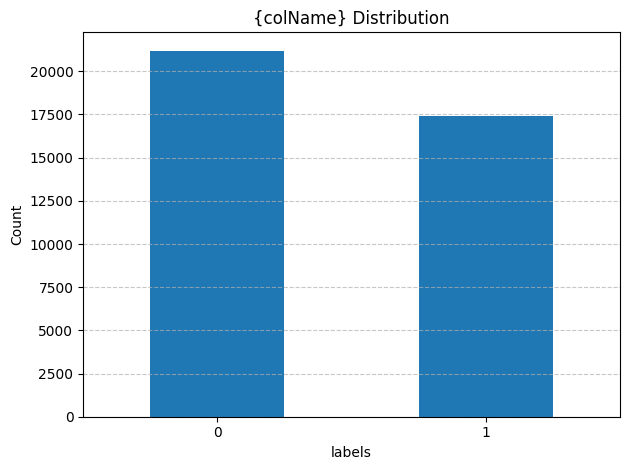

In [46]:
explore_distribution(df_merged, 'labels')

In [47]:
def plot_length_histograms(df_input):
    """
    Plot histograms of title and text lengths grouped by label.
    """
    df = df_input.copy()
    
    df['title_len'] = df['title'].astype(str).apply(len)
    df['text_len'] = df['text'].astype(str).apply(len)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    for label in df['labels'].unique():
        subset = df[df['labels'] == label]
        axes[0].hist(subset['title_len'], bins=50, alpha=0.5, label=label)
    axes[0].set_title("Comprimento do título por veracidade")
    axes[0].set_xlabel("Title Length")
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Fake")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    for label in df['labels'].unique():
        subset = df[df['labels'] == label]
        axes[1].hist(subset['text_len'], bins=50, alpha=0.5, label=label)
    axes[1].set_title("Comprimento do texto por veracidade")
    axes[1].set_xlabel("Text Length")
    axes[1].set_ylabel("Count")
    axes[1].legend(title="Fake")
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

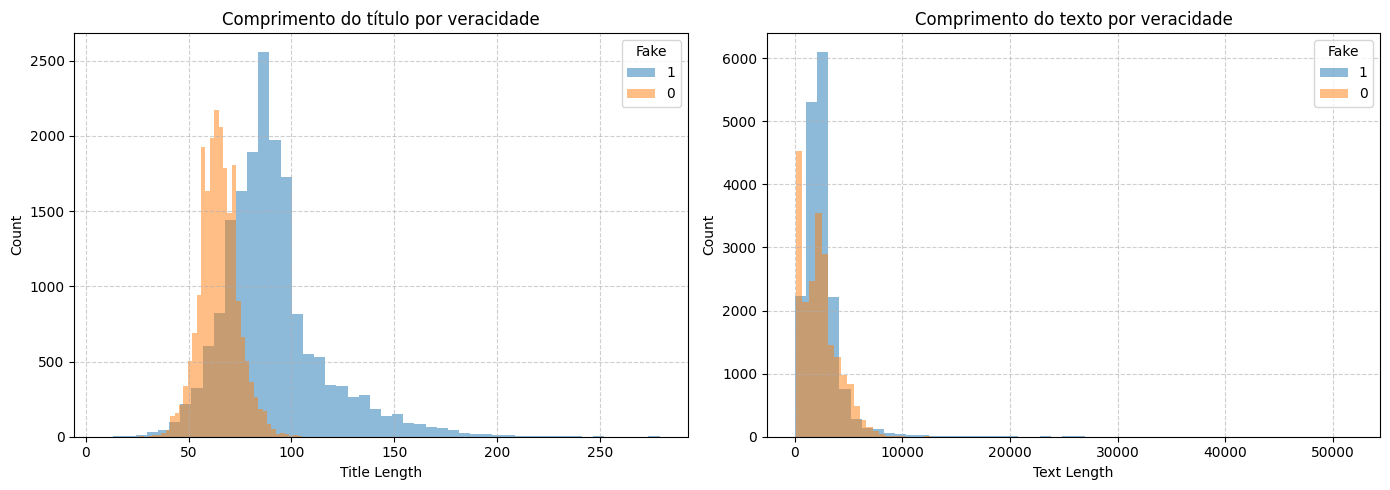

In [48]:
plot_length_histograms(df_merged)

In [49]:
def plot_common_words(df, column='text', top_n=30):
    """
    Plot most common words in a text column by label ('fake' vs 'true'),
    excluding stopwords.
    """
    def make_list(text):
        tokens = re.findall(r"\b\w+\b", str(text).lower())
        filtered = [word for word in tokens if word not in stop_words]
        return filtered

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for ax, label in zip(axes, [1, 0]):
        # Filtra o dataframe sem alterar o original
        texts = df[df['labels'] == label][column].apply(make_list)
        word_counts = Counter(word for tokens in texts for word in tokens)
        common = word_counts.most_common(top_n)
        words, counts = zip(*common)

        title = 'Fake' if label == 1 else 'True'

        sns.barplot(x=list(counts), y=list(words), ax=ax)
        ax.set_title(f"Top {top_n} Words in {column.capitalize()} ({title})")
        ax.set_xlabel("Count")
        ax.set_ylabel("Word")

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


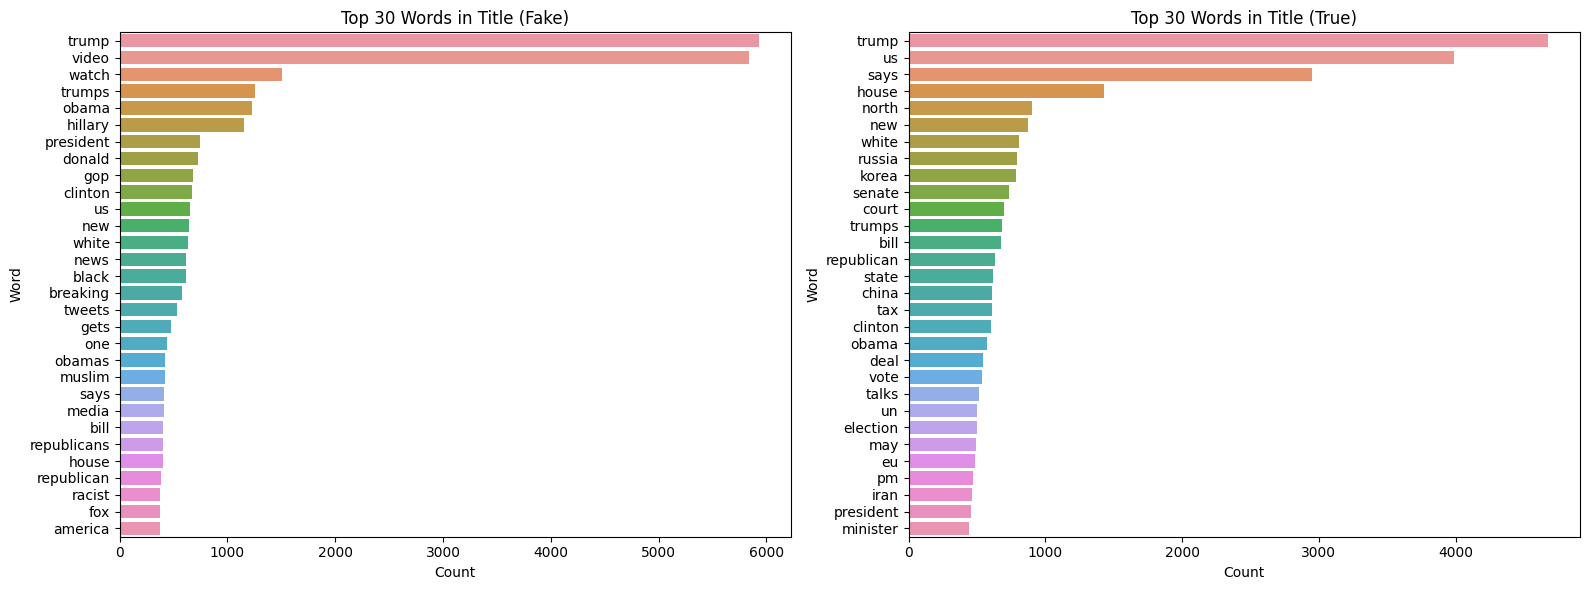

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


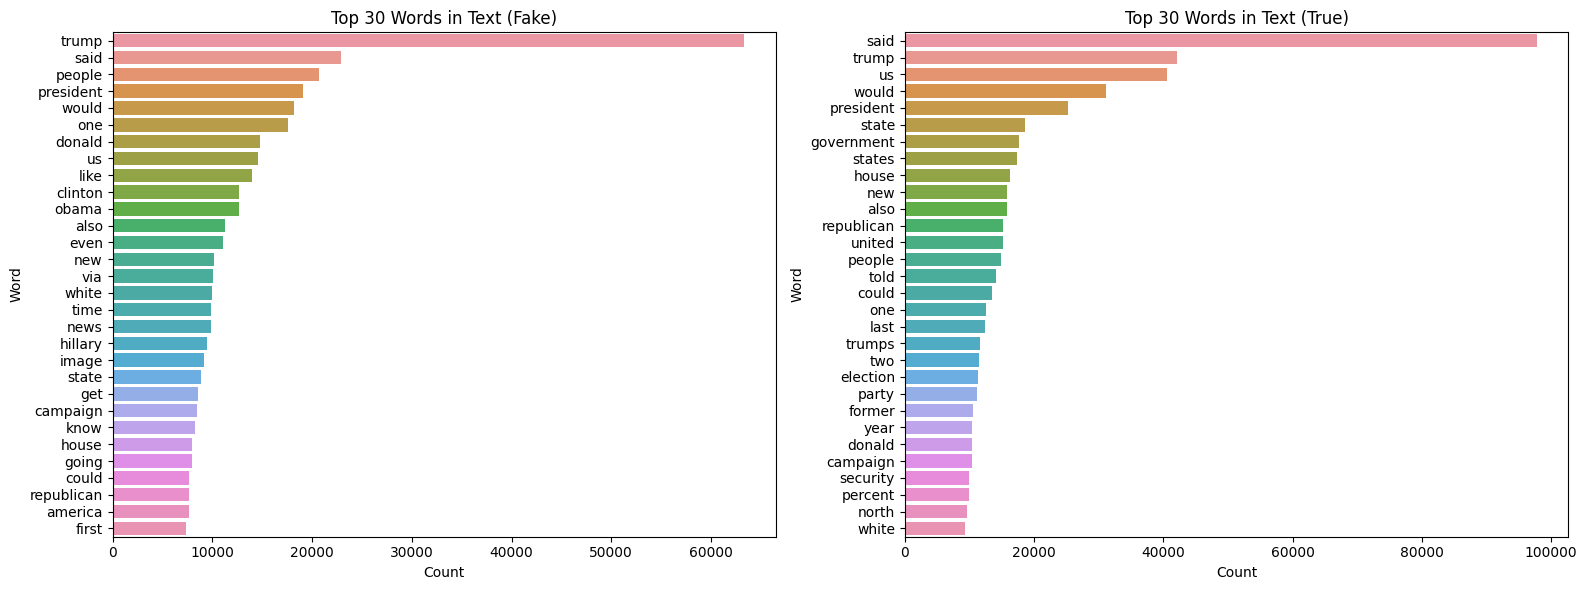

In [50]:
plot_common_words(df_merged_lstm, 'title')
plot_common_words(df_merged_lstm, 'text')

In [51]:
texts = df_merged_lstm['title'] + " " + df_merged_lstm['text']
all_words = ' '.join(texts).split()
word_freq = Counter(all_words)

print(f"Nº total de palavras: {len(all_words):,}")
print(f"Nº palavras únicas: {len(word_freq):,}")

Nº total de palavras: 9,275,739
Nº palavras únicas: 220,254


In [52]:
# Ordena as contagens
freqs = np.array(sorted(word_freq.values(), reverse=True))
total_words = freqs.sum()

# Calcula cobertura cumulativa
cumulative = freqs.cumsum() / total_words

# Mostra onde passa de 90%
idx_90 = np.argmax(cumulative >= 0.9)
print(f"Para cobrir 90%: {idx_90} palavras únicas")

Para cobrir 90%: 10788 palavras únicas


In [53]:
# Junta 'title' + 'text' ou só 'text'
texts = df_merged_lstm['title'] + ' ' + df_merged_lstm['text']

# Calcula quantas palavras por amostra
lengths = texts.apply(lambda x: len(x.split()))

# Estatísticas básicas
print(lengths.describe())

# Percentis úteis
print("90% das amostras têm até:", lengths.quantile(0.90))
print("95% das amostras têm até:", lengths.quantile(0.95))
print("99% das amostras têm até:", lengths.quantile(0.99))

count    38576.000000
mean       240.453624
std        181.645196
min          7.000000
25%        135.000000
50%        218.000000
75%        299.000000
max       4933.000000
dtype: float64
90% das amostras têm até: 434.0
95% das amostras têm até: 526.0
99% das amostras têm até: 766.5
